# MMD tests in Julia

## Setup

In [1]:
using LinearAlgebra
using Statistics
using Plots    # Plots takes a long time to compile
using Distributions

# Parallel computing to speed up Bootstrap MMD. It still takes time though
using Distributed
rmprocs(procs()[2:end])
addprocs(8) # This should be the number of simultaneous processes your computer can do

include("MMD.jl")
include("IterativeMethods.jl")
include("kernel_setup_script.jl")


kernel_setup_script.jl has set up the interpolation problem. 
 Interpolation matrix is k_Z and the corresponding x axis is Z The right hand side is f_z. 
 The interpolation matrix for plotting is k_YZ and the corresponding x axis is Y. 
 The direct solution to k_Z \ f_z is X_direct_solution.

In [2]:
N = length(f_Z)
samples = 500;
iter = 10;
N_mmd_bootstrap = 1000;

### Normal distribution sampling function

In [3]:
function mv_normal(mean::Array{Float64,1},cov::AbstractMatrix{Float64},N_samples::Int64=1)
    M = length(mean)
    F = svd(cov)
    cov = F.V*(F.S.*F.V')
    samples = zeros(M,N_samples)
    for i = 1:N_samples
        samples[:,i] = mean + cov*randn(N)
    end
    return samples
end


mv_normal (generic function with 2 methods)

In [4]:
mle_prior_N_samples = 5
mle_prior_samples = mv_normal(zeros(N), Diagonal(ones(N)), mle_prior_N_samples)

scale = 0
for i = 1:mle_prior_N_samples
    scale += norm(k_Z \ mle_prior_samples[:,i])^2
end
mle_prior_scale = scale / (N*mle_prior_N_samples)

5.425715125223759

# Methods

In [5]:
function run_richardson_default(prior, truth)
    x0 = rand(prior)
    IterativeMethods.Richardson(k_Z, k_Z*truth, x0, iter, 2/3)
end
function run_richardson_optimal(prior, truth)
    x0 = rand(prior)
    IterativeMethods.Richardson(k_Z, k_Z*truth, x0, iter, IterativeMethods.Optimal)
end
function run_richardson_adaptive(prior, truth)
    x0 = rand(prior)
    IterativeMethods.Richardson(k_Z, k_Z*truth, x0, iter, IterativeMethods.Adaptive)
end
function run_richardson_second_order(prior, truth)
    x0 = rand(prior)
    b = k_Z*truth
    prior2 = IterativeMethods.Richardson(k_Z, b, x0, iter, IterativeMethods.Optimal)
    IterativeMethods.Richardson2(k_Z, b, [prior2; x0], iter)[1:N]
end
function run_cg(prior, truth)
    x0 = rand(prior)
    IterativeMethods.cg(k_Z, k_Z*truth, x0, iter, 1e-10)
end
function run_bayescg(prior, truth)
    inverse_prior = inv(k_Z)
    b = k_Z*truth
    xm,sigm = IterativeMethods.bayescg(k_Z, b, mean(prior), cov(prior), iter, 1e-10)
    mv_normal(xm,sigm)
end

run_bayescg (generic function with 1 method)

## MMD Tests

### Setup

In [6]:
function run_mmd(input_samples, output_samples; n_samples=100, n_mmd_bootstrap=1000)
    ker = MMD.mmd_kernel_factory(input_samples, output_samples)
    mmd = MMD.mmd_p(input_samples,output_samples,ker)
    boot = MMD.bootstrap_mmd(input_samples[1:n_samples, :], output_samples[1:n_samples, :], ker, n_mmd_bootstrap)
    mmd, boot
end

function compute_q(mmd, boot)
    (length(boot[boot.>=mmd]))/(length(boot))
end

compute_q (generic function with 1 method)

In [7]:
all_priors = [
    Distributions.MvNormal(N, 1.0), # Identity
    Distributions.MvNormalCanon(zeros(N), k_Z), # Natural
    Distributions.MvNormal(zeros(N), mle_prior_scale*I) # MLE
];
all_methods = [
    run_richardson_default,
    run_richardson_optimal,
    run_richardson_adaptive,
    run_richardson_second_order,
    run_cg,
    run_bayescg
];

In [8]:
function broadcast_method(method, prior, truths)
    method_output = zeros(size(truths))
    for i = 1:size(truths, 1)
        method_output[i,:] = method(prior, truths[i,:])
    end
    method_output
end

broadcast_method (generic function with 1 method)

In [9]:
n_mmd_bootstrap = 1000
n_samples = 100

100

In [10]:
n_methods = length(all_methods);
n_priors = length(all_priors);
mmds = zeros(n_priors, n_methods);
bootstraps = Array{Float64, 3}(undef, n_priors, n_methods, n_mmd_bootstrap)
qs = zeros(n_priors, n_methods);

In [11]:
for prior_ix = 1:n_priors
    prior = all_priors[prior_ix]
    for method_ix = 1:n_methods
        print("Prior $prior_ix, Method $method_ix")
        method = all_methods[method_ix]
        
        print(" ... Sampling")
        s1 = rand(prior, n_samples)'
        truth = rand(prior, n_samples)'
        # map input sample to output sample
        method_output = broadcast_method(method, prior, truth)
        
        # bootstrap MMD on the output
        print(" ... Bootstrapping")
        mmd, bootstrap = run_mmd(s1, method_output, n_samples=n_samples, n_mmd_bootstrap=n_mmd_bootstrap)
        
        print(" ... Storing")
        bootstraps[prior_ix, method_ix, :] = bootstrap
        mmds[prior_ix, method_ix] = mmd
        qs[prior_ix, method_ix] = compute_q(mmd, bootstrap)
        println("")
    end
end

Prior 1, Method 1 ... Sampling ... Bootstrapping ... Storing
Prior 1, Method 2 ... Sampling ... Bootstrapping ... Storing
Prior 1, Method 3 ... Sampling ... Bootstrapping ... Storing
Prior 1, Method 4 ... Sampling ... Bootstrapping ... Storing
Prior 1, Method 5 ... Sampling ... Bootstrapping ... Storing
Prior 1, Method 6 ... Sampling ... Bootstrapping ... Storing
Prior 2, Method 1 ... Sampling ... Bootstrapping ... Storing
Prior 2, Method 2 ... Sampling ... Bootstrapping ... Storing
Prior 2, Method 3 ... Sampling ... Bootstrapping ... Storing
Prior 2, Method 4 ... Sampling ... Bootstrapping ... Storing
Prior 2, Method 5 ... Sampling ... Bootstrapping ... Storing
Prior 2, Method 6 ... Sampling ... Bootstrapping ... Storing
Prior 3, Method 1 ... Sampling ... Bootstrapping ... Storing
Prior 3, Method 2 ... Sampling ... Bootstrapping ... Storing
Prior 3, Method 3 ... Sampling ... Bootstrapping ... Storing
Prior 3, Method 4 ... Sampling ... Bootstrapping ... Storing
Prior 3, Method 5 ... Sa

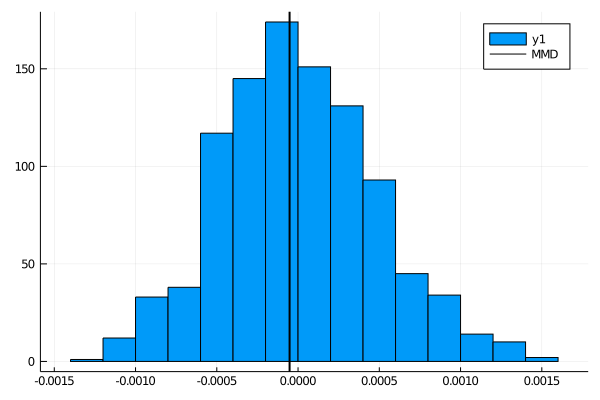

In [12]:
plot_prior_ix = 3
plot_method_ix = 5
histogram(bootstraps[plot_prior_ix, plot_method_ix, :])
vline!([mmds[plot_prior_ix, plot_method_ix]], linewidth=2, linecolor="black", label="MMD")

In [15]:
using Printf
function print_table(mmds, qs)
    for i = 1:size(mmds,1)
        print("& \\textsc{mmd}")
        for j = 1:size(mmds,2)
            @printf(" & %.2e", mmds[i,j])
        end
        println(" \\\\")
        print("& \$q\$")
        for j = 1:size(qs,2)
            @printf(" & %.2f", qs[i,j])
        end
        println(" \\\\\\hline")
    end
end

print_table (generic function with 1 method)

In [16]:
print_table(mmds, qs)

& \textsc{mmd} & -7.75e-06 & -3.52e-05 & 8.84e-05 & -2.46e-05 & 5.30e-05 & 9.17e-04 \\
& $q$ & 0.52 & 0.55 & 0.42 & 0.54 & 0.40 & 0.05 \\\hline
& \textsc{mmd} & -1.69e-04 & -1.95e-04 & -1.94e-04 & -2.42e-04 & -1.87e-04 & 2.88e-03 \\
& $q$ & 0.57 & 0.65 & 0.64 & 0.67 & 0.61 & 0.00 \\\hline
& \textsc{mmd} & 1.25e-04 & -2.74e-05 & 7.17e-05 & 8.83e-06 & -5.21e-05 & 4.45e-03 \\
& $q$ & 0.39 & 0.50 & 0.43 & 0.47 & 0.52 & 0.00 \\\hline


### Plots of Results

#### Richardson Bootstrap MMD Compared to MMD

In [18]:
histogram(boot_r, label="Bootstrap MMD Distribution")
vline!([results[1,1]], linewidth=2, linecolor="black", label="MMD")


UndefVarError: UndefVarError: boot_r not defined

#### Richardson compared to 1-$\alpha$

In [19]:
α = .99
histogram(boot_r, label="Bootstrap MMD Distribution")
vline!([1-α], linewidth=2, linecolor="black", label="1 - α")

UndefVarError: UndefVarError: boot_r not defined

#### BayesCG Bootstrap MMD Compared to MMD

In [20]:
histogram(boot_bayescg, label="Bootstrap MMD Distribution")
vline!([results[1,6]], linewidth=2, linecolor="black", label="MMD")


UndefVarError: UndefVarError: boot_bayescg not defined

#### BayesCG Bootstrap MMD compared to 1-$\alpha$

In [21]:
α = 0.99
histogram(boot_bayescg, label="Bootstrap MMD Distribution")
vline!([1-α], linewidth=2, linecolor="black", label="1 - α")


UndefVarError: UndefVarError: boot_bayescg not defined